In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
from skimage import measure                        
from shapely.geometry import Polygon, MultiPolygon
import json
import re
from google.colab import drive
import shutil
import zipfile
from random import shuffle,random

In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/images.zip", 'r')
zip_ref.extractall("/content/images")
zip_ref.close()

In [ ]:
def rotate(image,angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return image
def flip(image,flip):
  if(flip=='v'):
    image = cv2.flip(image ,0)
  elif(flip=='h'):
    image = cv2.flip(image ,1)
  else:
    image=cv2.flip(image,-1)
  return image
def contrast_brightness(image,alpha,beta):
  cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
  return image


In [ ]:
def create_sub_masks(mask_image):
    width, height = mask_image.size
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            pixel = mask_image.getpixel((x,y))[:3]
            if pixel != (0, 0, 0):
                pixel_str = str(pixel)
                sub_mask = sub_masks.get(pixel_str)
                if sub_mask is None:
                    sub_masks[pixel_str] = Image.new('1', (width+2, height+2))
                sub_masks[pixel_str].putpixel((x+1, y+1), 1)

    return sub_masks

def create_sub_mask_annotation(sub_mask, image_id, category_id, annotation_id, is_crowd):
    contours = measure.find_contours(sub_mask, 0.5, positive_orientation='low')
    segmentations = []
    polygons = []
    for contour in contours:
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)
        if (poly.area > 16): # Ignore tiny polygons
            if (poly.geom_type == 'MultiPolygon'):
                poly = poly.convex_hull
            if (poly.geom_type == 'Polygon'): # Ignore if still not a Polygon (could be a line or point)
                polygons.append(poly)
                segmentation = np.array(poly.exterior.coords).ravel().tolist()
                segmentation = np.array(poly.exterior.coords).ravel().tolist()
                segmentations.append(segmentation)
    multi_poly = MultiPolygon(polygons)
    x, y, max_x, max_y = multi_poly.bounds
    width = max_x - x
    height = max_y - y
    bbox = (x, y, width, height)
    area = multi_poly.area
    annotation = {
        'segmentation': segmentations,
        'iscrowd': is_crowd,
        'image_id': image_id,
        'category_id': category_id,
        'id': annotation_id,
        'bbox': bbox,
        'area': area
    }
    return annotation

In [ ]:
files=os.listdir('/content/')
images=[]
for i in files:
    if(re.search('.jpg',i)):
        images.append(i)

2.jpg


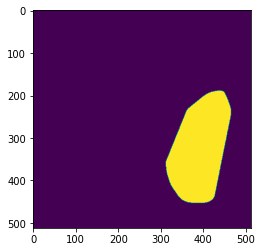

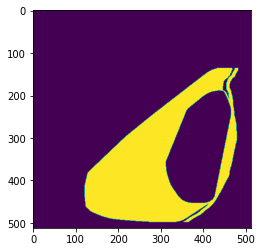

In [ ]:
submask_augmentation={}
data={}
data["info"]={
    "description": "Embryo Stained Dataset",
    "year":2021,
    "contributor":"PatSchnable Lab",
    "date_created": "2021/02/28"
}
data["licenses"]=[{"id": 0, 
          "name": "Sample Agreement"}]
data["images"]=[]
data["annotations"]=[]
data["categories"]= [{"supercategory": "kernel", "id": 1, "name": "plumule"}, {"supercategory": "kernel", "id": 2, "name": "embryo"}]
annotation_id=0
is_crowd=0
path='/content/'
for p in images:
        l=p[:-4]
        print(str(l)+'.jpg')
        image_id=str(l)
        file=str(l)+'.jpg'
        data["images"].append(
            {
            "license":0,
            "file_name":file,
            "width":512,
            "height":512,
            "id":l
            }
        )
        image=cv2.imread(path+file)
        image_original=cv2.imread(path+"original_images/"+str(l)+'.JPG')
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        
        #KERNEL
        
        cond_1=np.logical_and(image[:,:,0]>=50,image[:,:,0]<=75)
        cond_2=np.logical_and(image[:,:,1]>=170,image[:,:,1]<=200)
        cond_3=np.logical_and(image[:,:,2]>=240,image[:,:,2]<=255)
        lblue=np.where(np.logical_and(np.logical_and(cond_1,cond_2),cond_3))
        mask_kernel=np.zeros_like(image[:,:,0])
        index=[]
        for i in range(0,len(lblue[0])):
            index.append([lblue[0][i],lblue[1][i]])
        for i in index:
            mask_kernel[i[0],i[1]]=255
        s_k=mask_kernel.copy()
        s_k_color=(0,0,255)*np.ones_like(image)
        kernel = np.ones((25,1),np.uint8)
        mask_kernel = cv2.morphologyEx(mask_kernel, cv2.MORPH_DILATE, kernel)
        kernel = np.ones((1,25),np.uint8)
        mask_kernel = cv2.morphologyEx(mask_kernel, cv2.MORPH_DILATE, kernel)
        s_k_color=(0,0,255)*np.ones_like(image)
        s_k_color=cv2.bitwise_and(s_k_color,s_k_color,mask=mask_kernel)


        #PLUMULE
        cond_1=np.logical_and(image[:,:,0]>=20,image[:,:,0]<=100)
        cond_2=np.logical_and(image[:,:,1]>=180,image[:,:,1]<=255)
        cond_3=np.logical_and(image[:,:,2]>=50,image[:,:,2]<=100)
        green=np.where(np.logical_and(np.logical_and(cond_1,cond_2),cond_3))
        mask_plumule=np.zeros_like(image[:,:,0])
        index=[]
        for i in range(0,len(green[0])):
            index.append([green[0][i],green[1][i]])
        for i in index:
            mask_plumule[i[0],i[1]]=255
        s_p=mask_plumule.copy()
        contours, hierarchy = cv2.findContours(mask_plumule, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        hull=[]
        for i in range(len(contours)):
            hull.append(cv2.convexHull(contours[i], False))
        for i in range(len(contours)):
            cv2.drawContours(mask_plumule, contours, i,255, 30, 8, hierarchy)
            cv2.drawContours(mask_plumule, hull, i , 255, 30, 8)
        contours, hierarchy = cv2.findContours(mask_plumule, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours=sorted(contours,reverse=True,key=cv2.contourArea)     
        c=contours[0]
        s_p_color=np.zeros_like(image)
        cv2.drawContours(mask_plumule,[c],0,255,-1)
        plumule_indices=[]
        i_x=np.where(mask_plumule==255)
        for i in range(len(i_x[0])):
          plumule_indices.append((i_x[0][i],i_x[1][i]))

        cv2.drawContours(s_p_color,[c],0,(0,255,0),25)
        mask_green=[0,255,0]*np.ones_like(image)
        plumule=cv2.bitwise_and(mask_green,mask_green,mask=mask_plumule)
        

        #EMBRYO
        cond_1=np.logical_and(image[:,:,0]>=0,image[:,:,0]<=50)
        cond_2=np.logical_and(image[:,:,1]>=30,image[:,:,1]<=50)
        cond_3=np.logical_and(image[:,:,2]>=130,image[:,:,2]<=200)

        blue=np.where(np.logical_and(np.logical_and(cond_1,cond_2),cond_3))
        mask_embryo=np.zeros_like(image[:,:,0])
        index=[]
        for i in range(0,len(blue[0])):
            index.append([blue[0][i],blue[1][i]])
        for i in index:
            mask_embryo[i[0],i[1]]=255
        s_e=mask_embryo.copy()
        contours, hierarchy = cv2.findContours(mask_embryo, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        hull=[]
        for i in range(len(contours)):
            hull.append(cv2.convexHull(contours[i], False))
        for i in range(len(contours)):
            cv2.drawContours(mask_embryo, contours, i,255, 30, 8, hierarchy)
            cv2.drawContours(mask_embryo, hull, i , 255, 30, 8)
        contours, hierarchy = cv2.findContours(mask_embryo, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours=sorted(contours,reverse=True,key=cv2.contourArea)     
        c=contours[0]
        s_e_color=np.zeros_like(image)
        cv2.drawContours(mask_embryo,[c],0,255,-1)
        embryo_indices=[]
        i_x=np.where(mask_embryo==255)
        for i in range(len(i_x[0])):
          embryo_indices.append((i_x[0][i],i_x[1][i]))
        cv2.drawContours(s_e_color,[c],0,(255,0,0),25)
        mask_red=[255,0,0]*np.ones_like(image)
        embryo=cv2.bitwise_and(mask_red,mask_red,mask=np.subtract(mask_embryo,mask_plumule))
        embryo+=plumule
        
        #ASSEMBLING
        skeleton=s_e+s_k+s_p
        kernel = np.ones((25,1),np.uint8)
        mask = cv2.morphologyEx(skeleton, cv2.MORPH_DILATE, kernel)
        kernel = np.ones((1,25),np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cv2.drawContours(mask,[contours[0]],0,255,-1)     
        boxes = []
        for c in contours:
            (x, y, w, h) = cv2.boundingRect(c)
            boxes.append([x,y, x+w,y+h])
        boxes = np.asarray(boxes)
        x_coordinate, y_coordinate = np.min(boxes, axis=0)[:2]
        right, bottom = np.max(boxes, axis=0)[2:]
        width=right-x_coordinate
        height=bottom-y_coordinate
        i_x=np.where(mask==255)
        kernel_indices=[]
        for i in range(len(i_x[0])):
          kernel_indices.append((i_x[0][i],i_x[1][i]))
        whole=s_e_color+s_p_color+s_k_color
        resized_image=cv2.resize(cv2.cvtColor(image,cv2.COLOR_RGB2BGR)[y_coordinate:y_coordinate+height,x_coordinate:x_coordinate+width],(512,512),interpolation = cv2.INTER_NEAREST)
        image_copy=resized_image.copy()
        embryo_indices=np.array(embryo_indices)
        plumule_indices=np.array(plumule_indices)
        minimum_embryo=min(embryo_indices[:,1])
        maximum_embryo=max(embryo_indices[:,1])
        minimum_plumule=min(plumule_indices[:,1])
        maximum_plumule=max(plumule_indices[:,1])
        copy=whole.copy()
        if (abs(maximum_embryo-maximum_plumule)<abs(minimum_embryo-minimum_plumule)):
          orientation='r'
        else:
          orientation='l'
        copy_mask=np.zeros_like(copy[:,:,0])
        if(orientation=='r'):
          for i in embryo_indices:
            copy_mask[i[0],i[1]:]=255
        else:
            for i in embryo_indices:
                copy_mask[i[0],:i[1]]=255
        embryo_skeleton=cv2.bitwise_and(whole,whole,mask=np.uint8(copy_mask))
        gray=cv2.cvtColor(np.uint8(embryo_skeleton),cv2.COLOR_RGB2GRAY)
        ret,mask = cv2.threshold(gray,1,255,cv2.THRESH_BINARY)
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        embryo=(255,0,0)*np.ones_like(image)
        mask_embryo=np.zeros_like(image[:,:,0])    
        for i in range(0,len(contours)):
              cv2.drawContours(mask_embryo, contours,i, 255,-1, 8, hierarchy )
        contours, hierarchy = cv2.findContours(mask_embryo, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        mask_embryo=np.zeros_like(mask_embryo)
        c=sorted(contours,key=cv2.contourArea,reverse=True)[0]
        cv2.drawContours(mask_embryo, [c], 0,255, -1)       
        mask_embryo=np.absolute(mask_embryo-mask_plumule)
        embryo=cv2.bitwise_and(embryo,embryo,mask=mask_embryo)
        embryo_plumule=embryo+plumule
        r_mask=cv2.resize(embryo_plumule[y_coordinate:y_coordinate+height,x_coordinate:x_coordinate+width],(512,512),interpolation = cv2.INTER_NEAREST)
        resized_mask=np.zeros_like(r_mask)
        polygon_plumule=np.zeros_like(r_mask[:,:,0])
        polygon_embryo=np.zeros_like(r_mask[:,:,0])
        index_green=np.where(r_mask[:,:,1]>200 )
        index_red=np.where(r_mask[:,:,0]>200)      
        for i in range(0,len(index_green[0])):
          resized_mask[index_green[0][i],index_green[1][i]]=[0,255,0]
          polygon_plumule[index_green[0][i],index_green[1][i]]=255
        sub_mask_plumule=Image.fromarray(np.uint8(polygon_plumule))
        category_id='1'
        submask_augmentation[image_id]={}
        submask_augmentation[image_id][category_id]=polygon_plumule 
        plt.imshow(polygon_plumule)
        plt.show()
        data["annotations"].append(create_sub_mask_annotation(sub_mask_plumule, image_id, category_id, annotation_id, is_crowd))
        annotation_id+=1
        for i in range(0,len(index_red[0])):
          resized_mask[index_red[0][i],index_red[1][i]]=[255,0,0]
          polygon_embryo[index_red[0][i],index_red[1][i]]=255
        
        sub_mask_embryo=Image.fromarray(np.uint8(polygon_embryo))
        
        category_id='2'
        submask_augmentation[image_id][category_id]=polygon_embryo
        plt.imshow(polygon_embryo)
        plt.show()
        
        data["annotations"].append(create_sub_mask_annotation(sub_mask_embryo, image_id, category_id, annotation_id, is_crowd))
        annotation_id+=1
        cv2.imwrite(path+'images/'+str(l)+'.jpg',cv2.resize(image_original[y_coordinate:y_coordinate+height,x_coordinate:x_coordinate+width],(512,512),interpolation = cv2.INTER_NEAREST))

In [ ]:
import copy
data_copy = copy.deepcopy(data)

In [ ]:
annotation_id=12
image_id_augmentation=7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


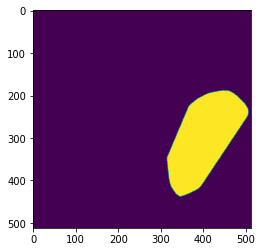

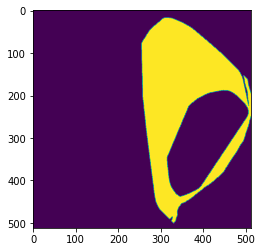

79


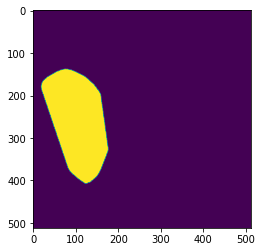

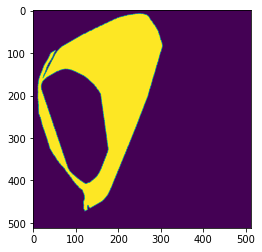

80


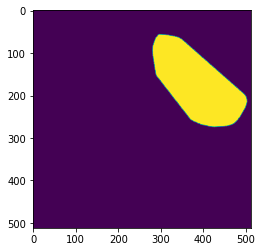

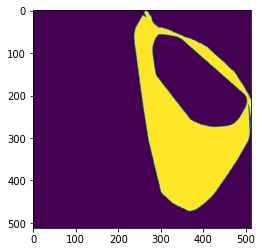

81


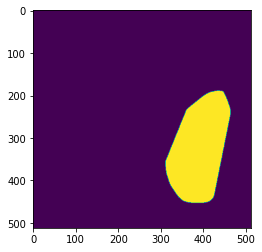

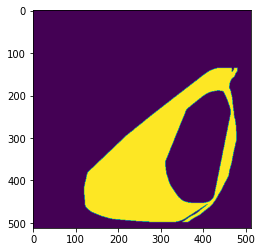

82


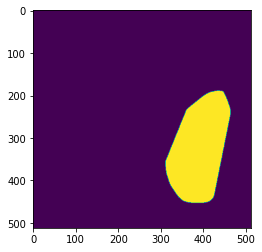

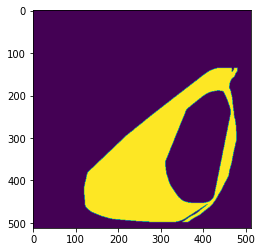

83


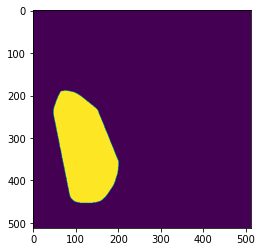

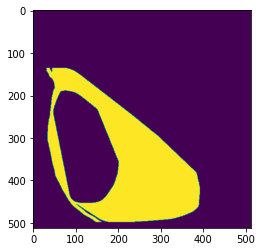

84


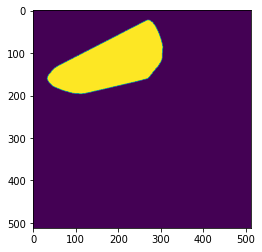

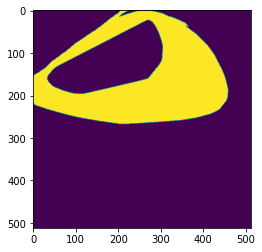

85


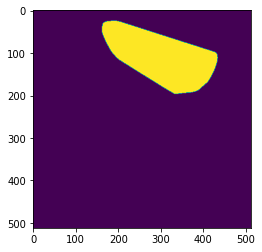

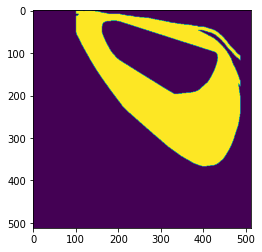

86


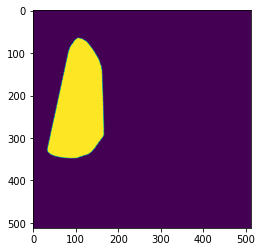

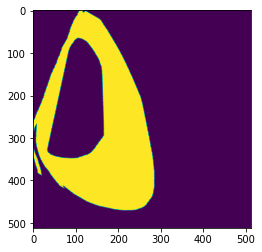

87


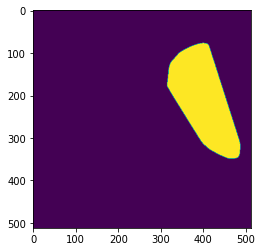

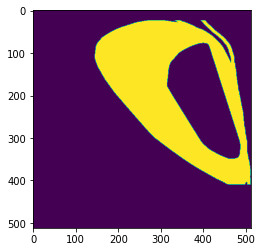

88


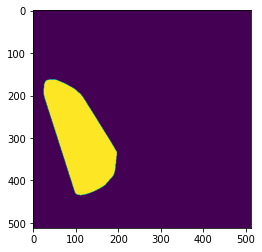

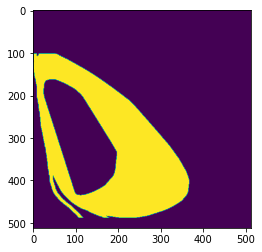

89


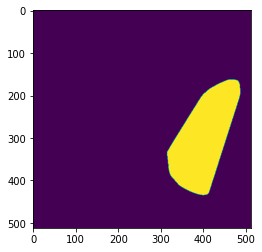

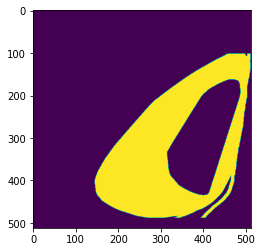

90


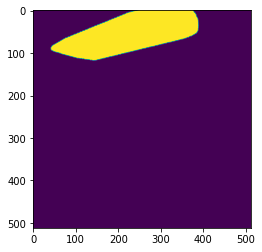

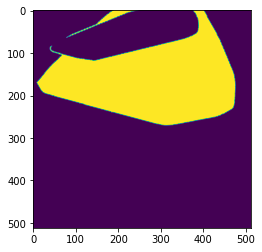

91


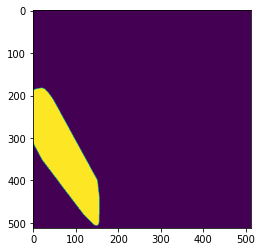

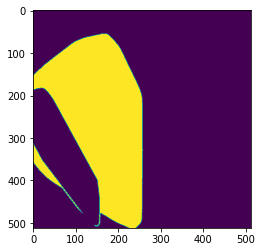

92


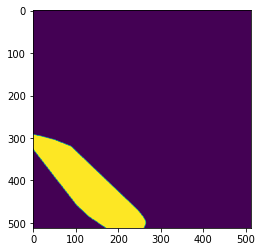

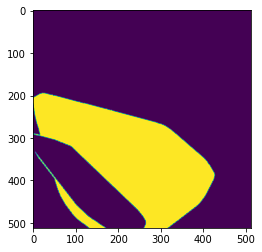

93


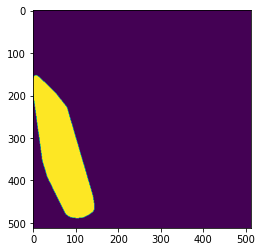

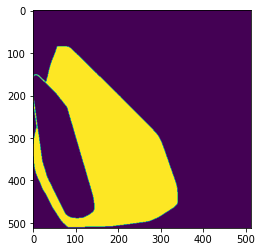

94


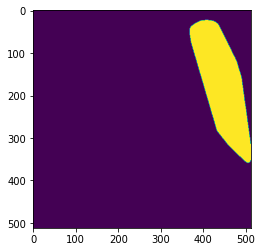

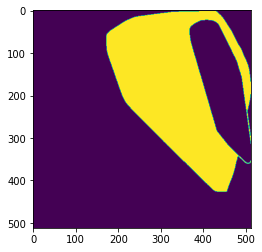

95


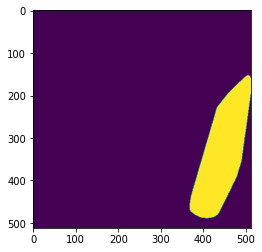

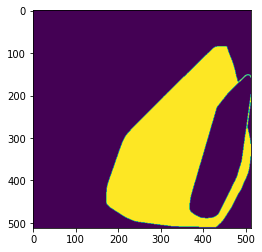

96


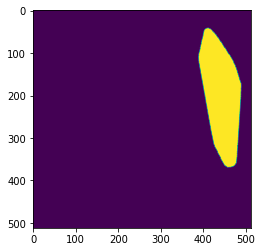

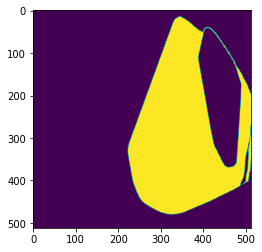

97


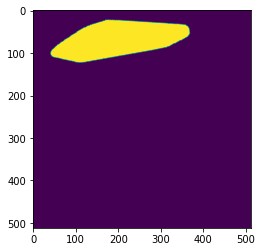

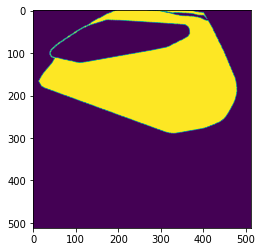

98


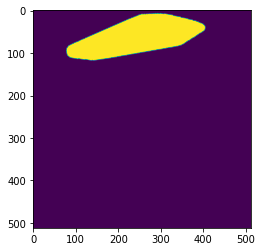

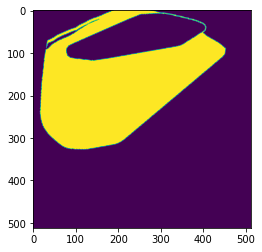

99


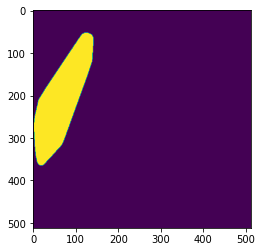

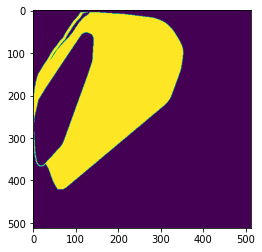

100


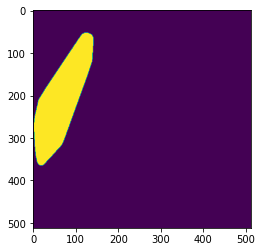

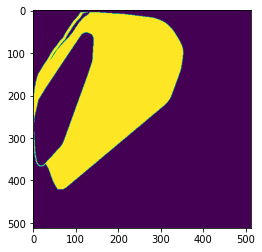

101


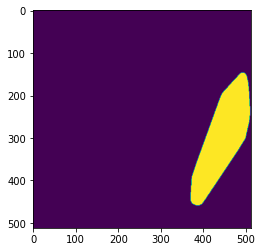

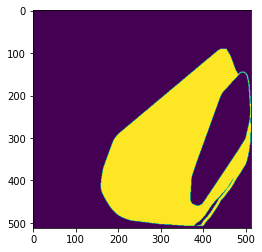

102


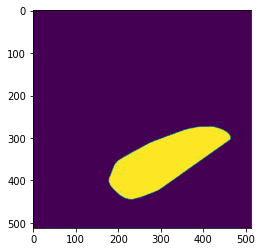

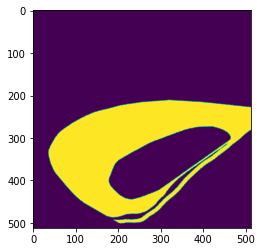

103


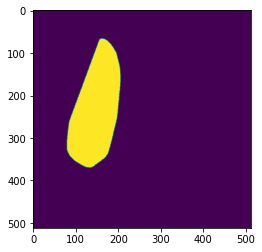

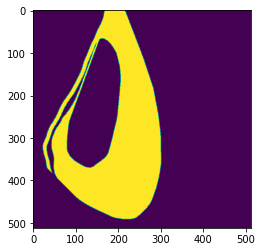

104


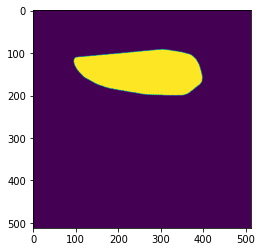

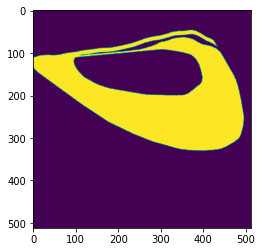

105


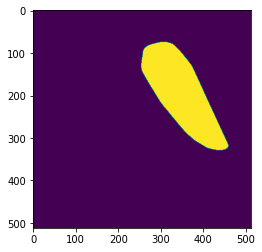

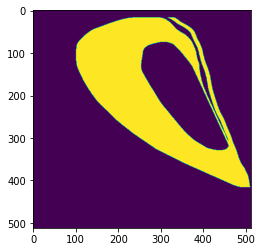

106


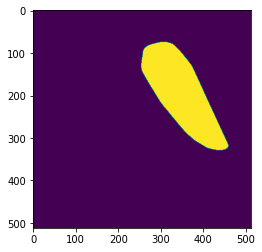

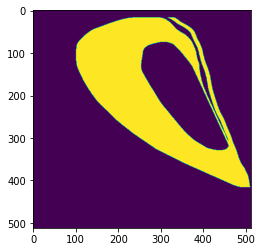

107


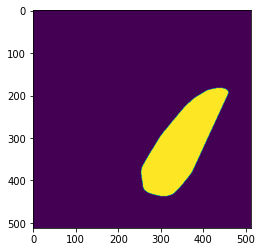

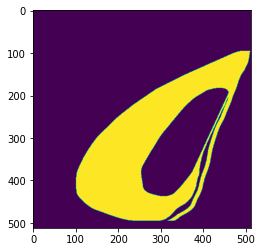

108


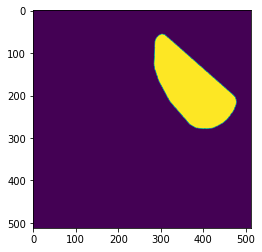

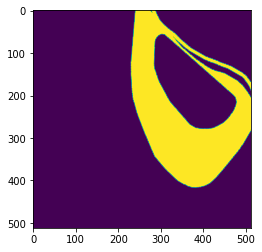

109


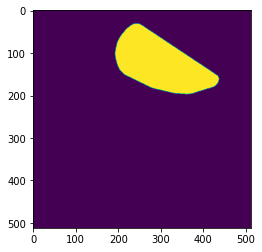

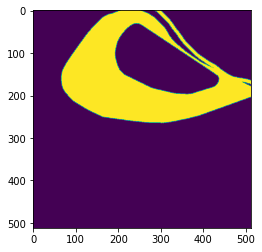

110


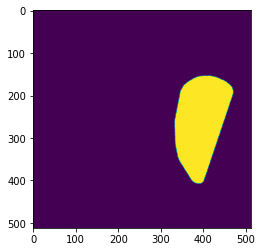

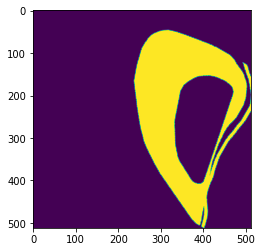

111


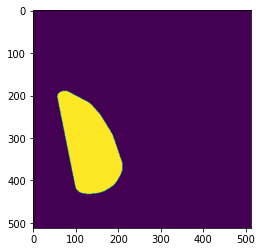

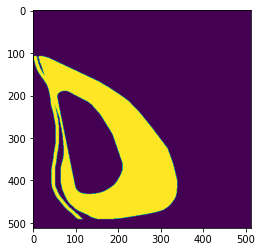

112


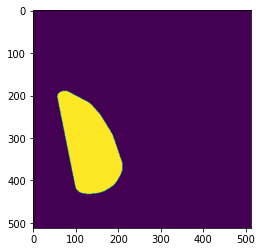

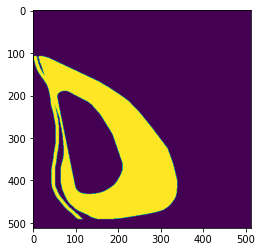

113


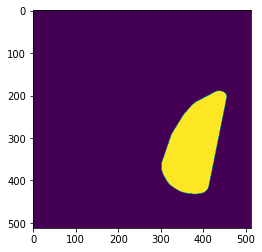

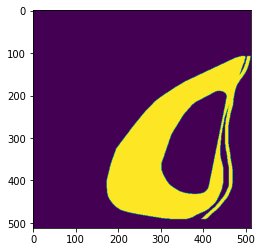

114


In [ ]:
from random import choice
import numpy as np
rotation_angles=[0,10,30,45,60,90,100,120,135,160,180,210,240,270,300,320,330]
flips=['v','h','hv']
beta=np.arange(0,110,10)
alpha=np.arange(1.0,3.2,0.2)
files=os.listdir('/content/images')

operation_string='012'
combinations = [operation_string[i: j] for i in range(len(operation_string))
          for j in range(i + 1, len(operation_string) + 1)]
        
for i in files:
  if(re.search('.jpg',i)):
    img=cv2.imread('/content/images/'+i)
    image_id=i[:-4]
    for operation in combinations:
      image=img.copy()
      mask_plumule=np.uint8(submask_augmentation[image_id]['1']).copy()
      mask_embryo=np.uint8(submask_augmentation[image_id]['2']).copy()
      for j in operation:
        if(j=='0'):
          angle=choice(rotation_angles)
          image=rotate(image,angle)

          mask_plumule=rotate(mask_plumule,angle)
          mask_embryo=rotate(mask_embryo,angle)
        if(j=='1'):
          flip_direction=choice(flips)
          image=flip(image,flip_direction)
          mask_plumule=flip(mask_plumule,flip_direction)
          mask_embryo=flip(mask_embryo,flip_direction)
        if(j=='2'):
          a=choice(alpha)
          b=choice(beta)
          image=contrast_brightness(image,a,b)
      
      if(mask_embryo!=[] and mask_plumule!=[]):
        mask_embryo=Image.fromarray(np.uint8(mask_embryo))
        mask_plumule=Image.fromarray(np.uint8(mask_plumule))
        plt.imshow(mask_plumule)
        plt.show()
        plt.imshow(mask_embryo)
        plt.show()
      else:
        mask_plumule=submask_augmentation[image_id]['1']
        mask_embryo=submask_augmentation[image_id]['2']
        plt.imshow(mask_plumule)
        plt.show()
        plt.imshow(mask_embryo)
        plt.show()
        mask_embryo=Image.fromarray(np.uint8(mask_embryo))
        mask_plumule=Image.fromarray(np.uint8(mask_plumule))
      category_id='1'
      data_copy['annotations'].append(create_sub_mask_annotation(mask_plumule, str(image_id_augmentation), category_id, annotation_id, is_crowd))
      annotation_id+=1
      category_id='2'
      data_copy['annotations'].append(create_sub_mask_annotation(mask_embryo, str(image_id_augmentation), category_id, annotation_id, is_crowd))
      annotation_id+=1
      data_copy['images'].append(
              {
              "license":0,
              "file_name":str(image_id_augmentation)+'.jpg',
              "width":512,
              "height":512,
              "id":str(image_id_augmentation)
              }
          )
      
      cv2.imwrite('/content/images_aug/'+str(image_id_augmentation)+'.jpg',image)
      print(image_id_augmentation)
      image_id_augmentation+=1        

In [ ]:
image_files=os.listdir('/content/val/images')
for i in image_files:
  if(re.search('.jpg',i)):
    os.remove('/content/val/images/'+i)

In [ ]:
image_files=os.listdir('/content/images/')
for i in image_files:
  if(re.search('.jpg',i)):
    shutil.copyfile('/content/images/'+i,'/content/images_aug/'+i[:-4]+'.jpg')

In [ ]:
splits=np.arange(1,115,1,dtype=np.int32)
shuffle(splits)

In [ ]:
train_indices=splits[0:int(0.7*len(splits))]
val_indices=splits[int(0.7*len(splits)):]

(79, 35)

In [ ]:
data_train={}
data_train["info"]={
    "description": "Embryo Stained Dataset",
    "year":2021,
    "contributor":"PatSchnable Lab",
    "date_created": "2021/02/28"
}
data_train["licenses"]=[{"id": 0, 
          "name": "Sample Agreement"}]
data_train["images"]=[]
data_train["annotations"]=[]
data_train["categories"]= [{"supercategory": "kernel", "id": 1, "name": "plumule"}, {"supercategory": "kernel", "id": 2, "name": "embryo"}]
annotation_id=0
is_crowd=0
annotations=copy.deepcopy(data_copy["annotations"])
image_info=copy.deepcopy(data_copy["images"])
image_info_train={}
annotations_train={}
image_id_train=0
for i in train_indices:
  for k in range(0,len(image_info)):
    if(image_info[k]['file_name']==str(i)+'.jpg'):
      images_train={
            "license":0,
            "file_name":str(image_id_train)+'.jpg',
            "width":512,
            "height":512,
            "id":str(image_id_train)
      }
      data_train["images"].append(images_train)
  
  for k in range(0,len(annotations)):
    if(annotations[k]['image_id']==str(i)):
        images_train={
            "segmentation":annotations[k]['segmentation'],
            "iscrowd":0,
            "image_id":str(image_id_train),
            "category_id":annotations[k]['category_id'],
            "bbox":annotations[k]['bbox'],
            "id":annotation_id,
            "area":annotations[k]['area']
        }
        data_train["annotations"].append(images_train)
        annotation_id+=1
        
  
  shutil.copyfile('/content/images_aug/'+str(i)+'.jpg','/content/train/images/'+str(image_id_train)+'.jpg')
  image_id_train+=1  

In [ ]:
coco_file=open('/content/train/train_annotations.json','w+')
coco_file.write(json.dumps(data_train))

394084

In [ ]:
data_val={}
data_val["info"]={
    "description": "Embryo Stained Dataset",
    "year":2021,
    "contributor":"PatSchnable Lab",
    "date_created": "2021/02/28"
}
data_val["licenses"]=[{"id": 0, 
          "name": "Sample Agreement"}]
data_val["images"]=[]
data_val["annotations"]=[]
data_val["categories"]= [{"supercategory": "kernel", "id": 1, "name": "plumule"}, {"supercategory": "kernel", "id": 2, "name": "embryo"}]
annotation_id=0
is_crowd=0
annotations=copy.deepcopy(data_copy["annotations"])
image_info=copy.deepcopy(data_copy["images"])
image_info_val={}
annotations_val={}
image_id_val=0
for i in val_indices:
  for k in range(0,len(image_info)):
    if(image_info[k]['file_name']==str(i)+'.jpg'):
      images_val={
            "license":0,
            "file_name":str(image_id_val)+'.jpg',
            "width":512,
            "height":512,
            "id":str(image_id_val)
      }
      data_val["images"].append(images_val)
  
  for k in range(0,len(annotations)):
    if(annotations[k]['image_id']==str(i)):
        images_val={
            "segmentation":annotations[k]['segmentation'],
            "iscrowd":0,
            "image_id":str(image_id_val),
            "category_id":annotations[k]['category_id'],
            "id":annotation_id,
            "bbox":annotations[k]['bbox'],
            "area":annotations[k]['area']
        }
        data_val["annotations"].append(images_val)
        annotation_id+=1
        
  
  shutil.copyfile('/content/images_aug/'+str(i)+'.jpg','/content/val/images/'+str(image_id_val)+'.jpg')
  image_id_val+=1  

In [ ]:
coco_file=open('/content/val/val_annotations.json','w+')
coco_file.write(json.dumps(data_val))

136248